In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm3
import matplotlib.pyplot as plt
import seaborn as sbn
import statsmodels.formula.api as smf
import theano.tensor as t

# The Right to Carry (Shall-issue) Law and Robbery Rate 

## Introduction
The Right to Carry, also known as Shall-issue law, has been at the center of public debate ever since its passing. It recognizes the right for anyone to carry a concealed weapon when away from home without a permit, or with a permit issued to an individual who meets the state's basic requirements. Today, 42 states out of 50 have adopted the Shall-issue law. Proponents of the law claim that it efficiently reduces crimes such as robbery as offenders may be deterred by the fact that their targets might possess firearms - as supported by researches done by Benson and Mast (2001). However, others claim that the effect of the law is the opposite, stating firearms are more readily available for potential criminals (Plassmann and Tideman (2001). For a comprehensive list on past studies regarding the controversy, see (https://www.rand.org/research/gun-policy/analysis/concealed-carry/violent-crime.html). 

Here I attempt to apply various bayesian modeling techniques to analyze the long-run effect of the right to carry law on robbery rate with a focus on state heterogeneities - states have various crime cultures that can lead to drastic differences in the efficacy and impact of the law, and this should not be ignored. 

## Data
Our data is a comprehensive dataset of major crime and crime-related control variables on all 50 U.S. states (excluding D.C.) from year 1970 to 2018. Below is a list of variables that we used:
 - lcrobpc: 100*log(robberies per capita), our main dependent variable
 - year：year from 1970-2018
 - state: state indexed from 0 to 49
 - shall_5: policy dummy variable that indicate if the Shall-issue law is in effect. It is lagged 5 years to account for the long run effect. Our policy of interest.
 
 Control variables: below are standard control variables for crime equations
 
 - unrate: unemployment rate
 - rtpi: real income per capita
 - employ: total employment
 - prate: poverty rate
 - rwel: Real welfare payments per capita
 - al_spir: alchohol consumption
 - density: population density

In [2]:
data = pd.read_csv('all_laws_2018.csv') 

data = data[['lcrrobpc', 'year', 'state', 'shall_5',  #Specify the variables we use
            #'lcm_5', 'syg_5', 'mmd_5', 'fse_5', 'onegun_5', 'concarry_5', 'permit_5',
            #'lcmfedst_5',  'bkgp_5', 'wait_5', 'safe_5', 'jban_5', 'snsban_5', 'strike3_5', 'tis_5',
            #'prcye_1', 'police_1' ,'ar', 
            'unrate', 'rtpi', 'employ', 'prate', 'rwel', 'al_spir','density']]
            #'suiratio_1',  ,  'al_beer', 'al_wine', 'fryer', 
            #'pq1519', 'pq2024',  'pq2529',  'pq3034',  'pq3539',  'pq4044',   'pq4554', 'pq5564',  'pq6500',
            #'bmq1519', 'bmq2024', 'bmq2529', 'bmq3034', 'bmq3539', 'bmq4044', 'bmq4554', 'bmq5564', 'bmq6500']] 

data = data.dropna(subset = ['year'])
data['year'] = data['year'].apply(int) #Change years to integers 

years = np.arange(1970, 2019, 1) #1970 - 2018
data = data[data.year.isin(years) == True] #remove the years with no data 

data.state = data.state.apply(int)  #Change state index to integers

#crrobpc_1 crburpc_1 
#unrate rtpi employ  empmil empcon  prate rwel
#suiratio_1  al_spir al_beer al_wine fryer density
# pq1519  pq2024  pq2529  pq3034  pq3539  pq4044 pq4554 pq5564  pq6500
# bmq1519 bmq2024 bmq2529 bmq3034 bmq3539 bmq4044 bmq4554 bmq5564 bmq6500
#/* Change made by script */
#lcrrobpc_1 lcrrobpc_2   

#Removing the state_8(DC) index
temp = []
for s in data.state.values:
    if s >= 9:
        temp.append(s-1)
    else:
        temp.append(s)
data['state'] = temp
temp = []

data.state = data.state-1  #Make it 0-indexed

In [3]:
data.head()

,lcrrobpc,year,state,shall_5,unrate,rtpi,employ,prate,rwel,al_spir,density
20,391.4175,1970,0,0.0,5.9,7.929389,409.0041,21.6,121.1637,503.2049,68.07814
21,404.8809,1971,0,0.0,5.5,8.259730,407.0109,20.8,125.0753,557.3936,68.92143
22,421.9424,1972,0,0.0,4.5,8.784830,415.4016,20.0,128.5492,571.7537,69.76200
23,436.2424,1973,0,0.0,4.5,9.207684,426.1574,19.2,128.5896,584.7001,70.56517
24,458.6872,1974,0,0.0,5.5,9.080877,427.8834,18.4,159.8104,599.7610,71.49176


In [4]:
data.describe()

,lcrrobpc,year,state,shall_5,unrate,rtpi,employ,prate,rwel,al_spir,density
count,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000
mean,449.223942,1994.000000,24.500000,0.291020,5.913551,15.276316,550.859180,12.934122,215.567669,696.571346,173.601519
std,85.560470,14.145023,14.433816,0.454326,2.053561,3.822318,68.961592,3.910201,94.025183,290.675992,240.548664
min,184.220700,1970.000000,0.000000,0.000000,2.000000,7.035669,370.960900,2.900000,0.331781,276.559600,0.533836
25%,412.127350,1982.000000,12.000000,0.000000,4.400000,12.360185,500.366150,9.900000,145.306975,523.395225,35.389120
50%,463.958850,1994.000000,24.500000,0.000000,5.500000,14.816990,553.429600,12.300000,198.500600,631.797950,85.410510
75%,505.703000,2006.000000,37.000000,1.000000,7.000000,17.645605,599.514750,15.300000,275.764375,794.451350,184.932225
max,652.946100,2018.000000,49.000000,1.000000,17.800000,30.448510,823.167700,30.800000,548.527900,2898.264000,1201.040000


First, we look at how robbery rate differs for states that do and do not have the Shall-issue law in place for the year: 

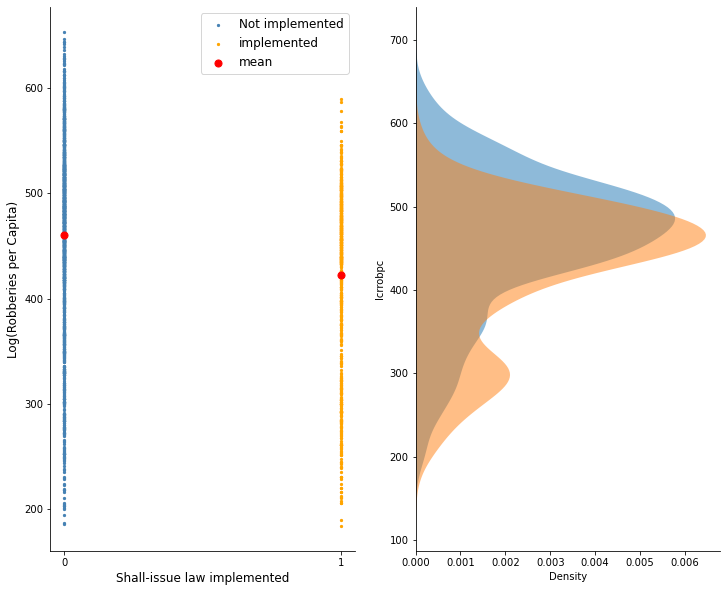

In [5]:


fig2 = plt.figure(figsize=(12,10))
ax2 = fig2.add_subplot(121)
ax2.scatter(data[data.shall_5 == 0].shall_5, data[data.shall_5 == 0].lcrrobpc, s=5, c=['steelblue']);
ax2.scatter(data[data.shall_5 == 1].shall_5, data[data.shall_5 == 1].lcrrobpc, s=5, c=['orange']);


#Identifying the state lcrrobpc yearly means
means = pd.DataFrame(data.groupby('shall_5')['lcrrobpc'].mean())
ax2.scatter(means.index, means.lcrrobpc, s=50, c='r');

ax2.set_xticks([0., 1.])

ax2.set_ylabel('Log(Robberies per Capita)', fontsize='large');
ax2.set_xlabel('Shall-issue law implemented', fontsize='large'); 
ax2.legend(['Not implemented', 'implemented', 'mean'], fontsize='large')

ax3 = fig2.add_subplot(122)
#ax3.legend(['Not implemented', 'implemented'], fontsize='large')

sbn.kdeplot(data=data, y=data[data.shall_5 == 0]['lcrrobpc'], fill=True,  alpha=.5, linewidth=0)
sbn.kdeplot(data=data, y=data[data.shall_5 == 1]['lcrrobpc'], fill=True,  alpha=.5, linewidth=0)
sbn.despine()

plt.show()

We see that with the implementation of the shall-issue law, mean robbery rate and its std. across states/time periods seem to be lower. In addition, the law seems to have an effect on reducing the number of states with extremely high robbery rate, condense the average robbery rate towards the center and creating a fatter tail towards low robbery rate states.


Now, we plot out each states' robbery rate:

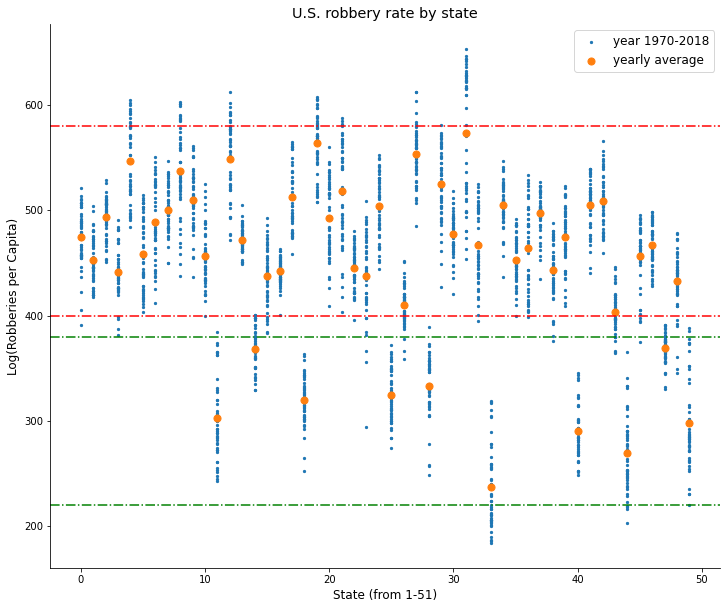

In [6]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(data.state, data.lcrrobpc, s=5);

#Identifying the state lcrrobpc yearly means
means = pd.DataFrame(data.groupby('state')['lcrrobpc'].mean())
ax.scatter(means.index, means.lcrrobpc, s=50);

ax.axhline(y=380, color='g', linestyle='-.')
ax.axhline(y=220, color='g', linestyle='-.')

ax.axhline(y=400, color='r', linestyle='-.')
ax.axhline(y=580, color='r', linestyle='-.')



ax.set_ylabel('Log(Robberies per Capita)', fontsize='large');
ax.set_xlabel('State (from 1-51)', fontsize='large'); 
ax.legend(['year 1970-2018', 'yearly average'], fontsize='large')
ax.set_title('U.S. robbery rate by state', fontsize='x-large')
sbn.despine()
plt.show()

We see that robbery rates across states are quite distinct, ranging from 180 to 650. This heterogeneity is also clearly seen from the orange dots, indicating each state's robbery rate yearly means. Thus, a pooled model will not be sufficient, as the pooled intercept and policy coefficient completely disregard this characteristic. However, we see that the states can be divided into "safe"(green) and "dangerous"(red) regions and robbery rates are clustered in those two regions. These clusters might call for a hierarchical model, as it allows states with similar crime levels to utilize an overarching parent distribution. 



Therefore, we estimate 3 types of models and compare their results. Our crime equation is estimated by:

$$
log(Y_{it}) = State_i + \beta_0Shall_{it} + \sum_{j=1}^7 {\beta_j Control_{j,it}} + u_{it}
$$

$State_i$ is the state intercept, $Shall_{it}$ is 0 if state $i$ at time $t$ does not have shall-issue law in place, and 1 if it does. $Control_{j,it}$ is our control variable $j \in [1, 2...7]$ 

## Model 1: Mixed Fixed Effects 

First, we estimate model 1 using a mixed model with an unpooled state intercept and pooled coefficients for the policy/control variables:

Writing this model as Bayesian we have

- Priors
\begin{eqnarray}
State_i &\sim& U(0,800) \nonumber\\
\beta_0 &\sim& U(-500,500) \nonumber\\
\beta_j &\sim& N(0,50), j \in [1,2,...,7]\nonumber\\
\sigma &\sim& HalfCauchy(0, 5) \\
\end{eqnarray}

- Likelihood
\begin{equation}
log(Y_{it}) \sim N(State_i + \beta_0Shall_{it} + \sum_{j=1}^7 {\beta_j Control_{j,it}}, \sigma) \nonumber
\end{equation}

### Results

In [8]:
#Creating state dummies (missing state_9 - DC)
data = data.join(pd.get_dummies(data.state, prefix='state'))

data = data.sort_values(ascending=True, by=['year','state'])

state_idx = data['state'].values.astype(int) #Creating state index for unpooled/hierarchical models
state_n = len(np.unique(data.state)) #number of states

control_n = len(data.columns[4:11]) #number of control variables (7)

In [8]:
with pm3.Model() as model_1:
    #Priors for intercept and sigma 
    intercept_state = pm3.Uniform('State Intercept', lower=0, upper=800, shape=state_n)
    sigma = pm3.HalfCauchy('sigma', beta = 5.)
    #b_controls = pm3.Normal("b_controls", mu=0, sigma=50, shape=control_n)
    
    #Prior for policy variable
    shall_5 = pm3.Uniform('Shall_5', lower=-500, upper=500)
    
    #Priors for Controls
    unrate = pm3.Normal('unrate', mu=0, sigma=50)
    rtpi = pm3.Normal('rtpi', mu=0, sigma=50)
    employ = pm3.Normal('employ', mu=0, sigma=50)
    prate = pm3.Normal('prate', mu=0, sigma=50)
    rwel = pm3.Normal('rwel', mu=0, sigma=50)
    al_spir = pm3.Normal('al_spir', mu=0, sigma=50)
    density = pm3.Normal('density', mu=0, sigma=50) 
    
    mu_it = intercept_state[state_idx] + shall_5 * data.shall_5 + \
            unrate * data.unrate + rtpi * data.rtpi\
            +employ * data.employ + prate * data.prate + rwel * data.rwel\
            +al_spir * data.al_spir + density * data.density
    #Likelihood
    like = pm3.Normal('likelihood', mu = mu_it, 
                      sigma = sigma, observed=data.lcrrobpc)

In [9]:
with model_1:
    trace_1 = pm3.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [density, al_spir, rwel, prate, employ, rtpi, unrate, Shall_5, sigma, State Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 202 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'unrate'}>,
        <AxesSubplot:title={'center':'unrate'}>],
       [<AxesSubplot:title={'center':'rtpi'}>,
        <AxesSubplot:title={'center':'rtpi'}>],
       [<AxesSubplot:title={'center':'employ'}>,
        <AxesSubplot:title={'center':'employ'}>],
       [<AxesSubplot:title={'center':'prate'}>,
        <AxesSubplot:title={'center':'prate'}>],
       [<AxesSubplot:title={'center':'rwel'}>,
        <AxesSubplot:title={'center':'rwel'}>],
       [<AxesSubplot:title={'center':'al_spir'}>,
        <AxesSubplot:title={'center':'al_spir'}>],
       [<AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'State Intercept'}>,
        <AxesSubplot:title={'center':'State Intercept'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'Shall_5'}>,
        <AxesSubplot:title={'center':'Shall_5'}>]

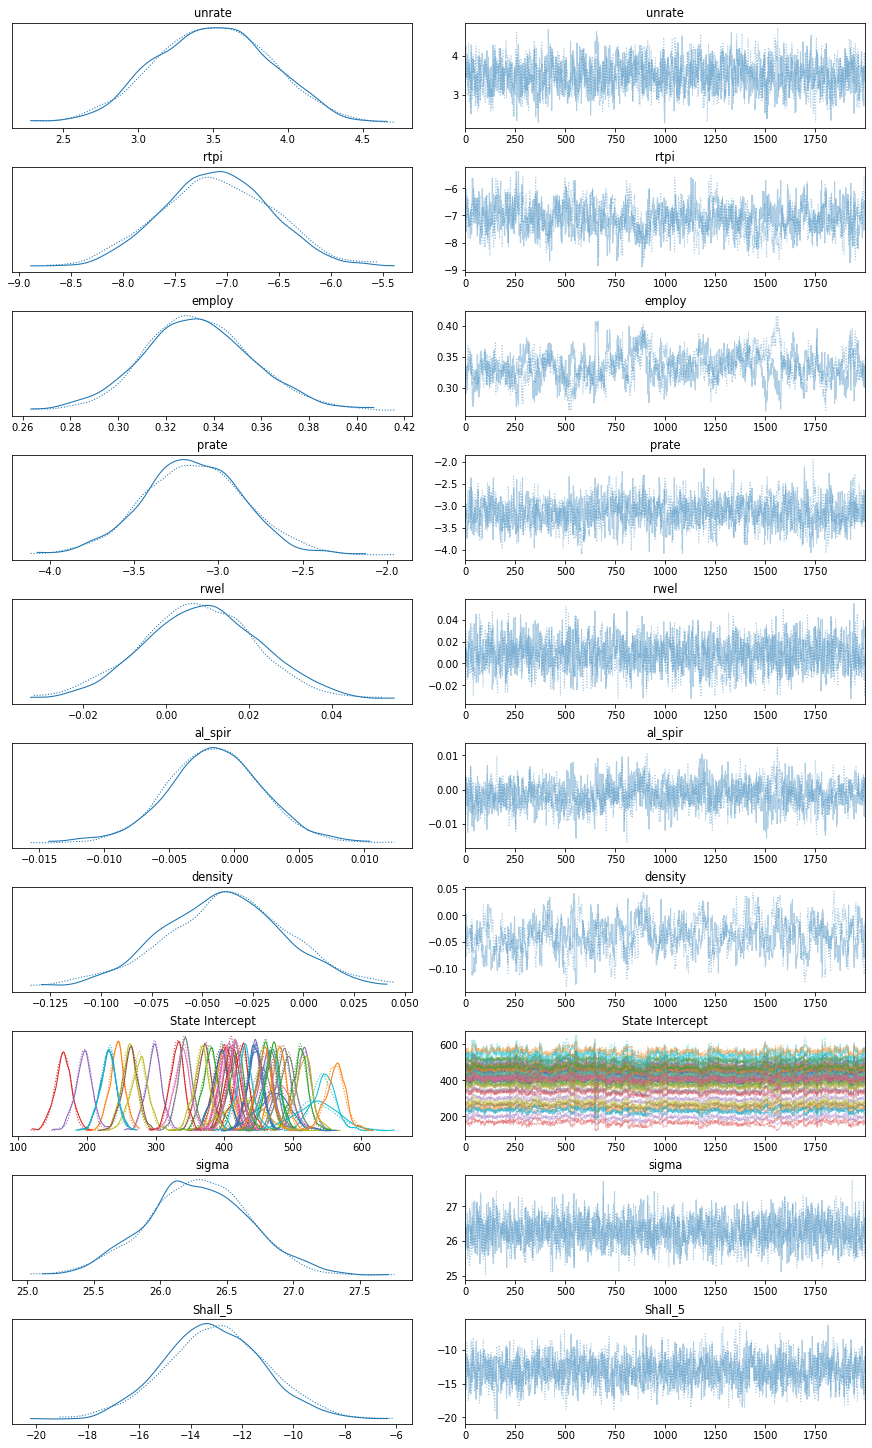

In [10]:
pm3.plot_trace(trace_1)

*Only in this model we plot out traces for the control variables individually to better visualize their results, later they will be condensed into one graph, as they are not necessarily our variables of interest.

In [11]:
pm3.summary(trace_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
unrate,3.499,0.383,2.831,4.247,0.014,0.010,753.0,1284.0,1.00
rtpi,-7.105,0.536,-8.097,-6.098,0.031,0.022,293.0,936.0,1.01
employ,0.334,0.023,0.293,0.380,0.002,0.001,126.0,222.0,1.01
prate,-3.149,0.300,-3.755,-2.619,0.012,0.009,600.0,969.0,1.00
rwel,0.008,0.014,-0.018,0.034,0.000,0.000,1174.0,1666.0,1.00
al_spir,-0.001,0.004,-0.009,0.005,0.000,0.000,337.0,760.0,1.00
density,-0.039,0.030,-0.097,0.017,0.002,0.001,239.0,556.0,1.01
State Intercept[0],443.966,11.198,422.716,464.756,1.102,0.782,103.0,195.0,1.01
State Intercept[1],397.535,11.792,374.515,418.573,1.072,0.760,122.0,226.0,1.01
State Intercept[2],458.395,10.837,437.036,478.119,1.068,0.758,103.0,200.0,1.01


### Discussions
1. As expected, we see a large amount of heterogeneity in the state intercepts, with means ranging from 163 to 542. This validates our intuition that some states have deeply rooted crime cultures and naturally are more dangerous than others without considering any policy implementation. 
2. We see that the pooled Shall_5 coefficient is around -13, indicating that taking the state crime heterogeneities into account, the passing of the Shall-issue law decreases general robbery rate in the long run.

## Model 2: Unpooled

Now, we estimate model 2 - a mixed model with unpooled state intercept and policy coefficient, and estimate pooled coefficients for the control variables. We change the policy coefficient to be unpooled, because 1. we may want to know the state-level policy effect rather than its' aggregate effect as a whole and 2. Some states have just adopted the shall-issue law recently and some even never adopted it, we want to isolate and minimize the impact of those data entries on our model.

The Bayesian model is expressed as:

- Priors
\begin{eqnarray}
State_i &\sim& U(0,800) \nonumber\\
\beta_{0i} &\sim& U(-200,200) \nonumber\\
\beta_j &\sim& N(0,50), j \in [1,2,...,7]\nonumber\\
\sigma &\sim& HalfCauchy(0, 5) \\
\end{eqnarray}

- Likelihood
\begin{equation}
log(Y_{it}) \sim N(State_i + \beta_{0i}Shall_{it} + \sum_{j=1}^7 {\beta_j Control_{j,it}}, \sigma) \nonumber
\end{equation}

### Results

In [12]:
with pm3.Model() as model_2:
    #Priors for intercept and sigma 
    intercept_state = pm3.Uniform('State Intercept', lower=0, upper=800, shape=state_n)
    sigma = pm3.HalfCauchy('sigma', beta = 5.)

    shall_5 = pm3.Uniform('Shall_5', lower=-200, upper=200, shape=state_n)        #Priors for policy variable
    b_controls = pm3.Normal("b_controls", mu=0, sigma=50, shape=control_n)        #Priors for Controls

    mu_it = intercept_state[state_idx] + shall_5[state_idx] * data.shall_5 + t.dot(data.iloc[:, 4:11].values, b_controls)

    #Likelihood
    like = pm3.Normal('likelihood', mu = mu_it, 
                      sigma = sigma, observed=data.lcrrobpc)

    trace_2 = pm3.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_controls, Shall_5, sigma, State Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 255 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'b_controls'}>,
        <AxesSubplot:title={'center':'b_controls'}>],
       [<AxesSubplot:title={'center':'State Intercept'}>,
        <AxesSubplot:title={'center':'State Intercept'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'Shall_5'}>,
        <AxesSubplot:title={'center':'Shall_5'}>]], dtype=object)

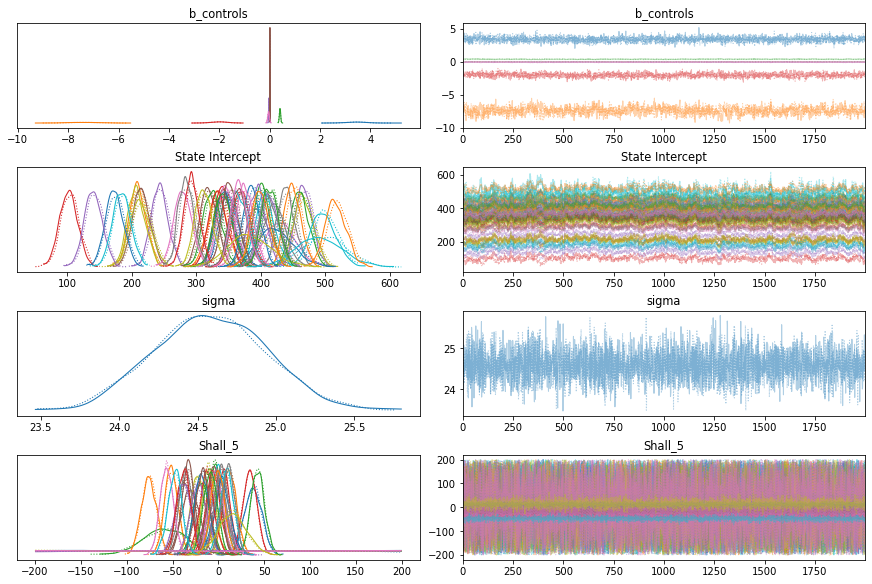

In [13]:
pm3.plot_trace(trace_2)

In [14]:
pm3.summary(trace_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_controls[0],3.448,0.381,2.762,4.178,0.010,0.007,1574.0,3035.0,1.00
b_controls[1],-7.412,0.568,-8.450,-6.308,0.027,0.019,444.0,1519.0,1.01
b_controls[2],0.409,0.026,0.360,0.456,0.003,0.002,104.0,317.0,1.03
b_controls[3],-2.013,0.311,-2.609,-1.437,0.012,0.008,674.0,2253.0,1.01
b_controls[4],-0.024,0.014,-0.049,0.003,0.000,0.000,1804.0,3050.0,1.00
...,...,...,...,...,...,...,...,...,...
Shall_5[45],-17.091,7.548,-31.141,-3.431,0.094,0.076,6410.0,2955.0,1.00
Shall_5[46],-0.295,116.164,-186.631,188.820,1.394,2.191,6356.0,2881.0,1.00
Shall_5[47],10.620,7.071,-2.494,23.413,0.099,0.074,5081.0,2841.0,1.00
Shall_5[48],15.156,15.062,-12.445,44.277,0.171,0.194,7788.0,2765.0,1.00


### Discussions

1. The posterior distributions for both the state coefficient and control variables are very identical to those of model 1, only with centers shifted towards the left, indicating lower state robbery cultures.

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
unrate   3.499  0.383   2.831    4.247      0.014    0.010     753.0   
rtpi    -7.105  0.536  -8.097   -6.098      0.031    0.022     293.0   
employ   0.334  0.023   0.293    0.380      0.002    0.001     126.0   
prate   -3.149  0.300  -3.755   -2.619      0.012    0.009     600.0   
rwel     0.008  0.014  -0.018    0.034      0.000    0.000    1174.0   
al_spir -0.001  0.004  -0.009    0.005      0.000    0.000     337.0   
density -0.039  0.030  -0.097    0.017      0.002    0.001     239.0   

         ess_tail  r_hat  
unrate     1284.0   1.00  
rtpi        936.0   1.01  
employ      222.0   1.01  
prate       969.0   1.00  
rwel       1666.0   1.00  
al_spir     760.0   1.00  
density     556.0   1.01  
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_controls[0]  3.448  0.381   2.762    4.178      0.010    0.007    1574.0   
b_controls[1] -7.412  0.568  -8.450   -6.308      0

/tmp/ipykernel_43/1503819018.py:4: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm3.traceplot(var_names=['State Intercept'], data=trace_1)
/tmp/ipykernel_43/1503819018.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm3.traceplot(var_names=['State Intercept'], data=trace_2)


array([[<AxesSubplot:title={'center':'State Intercept'}>,
        <AxesSubplot:title={'center':'State Intercept'}>]], dtype=object)

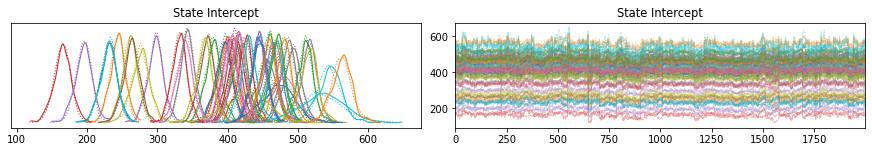

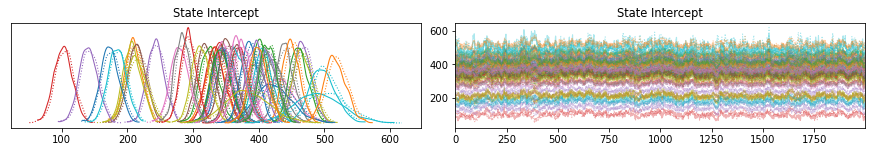

In [15]:
print(pm3.summary(trace_1)[:7])
print(pm3.summary(trace_2)[:7])

pm3.traceplot(var_names=['State Intercept'], data=trace_1)
pm3.traceplot(var_names=['State Intercept'], data=trace_2)

2. Our sigma is slightly reduced

/tmp/ipykernel_43/3857104812.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm3.traceplot(var_names=['sigma'], data=trace_1)
/tmp/ipykernel_43/3857104812.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm3.traceplot(var_names=['sigma'], data=trace_2)


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

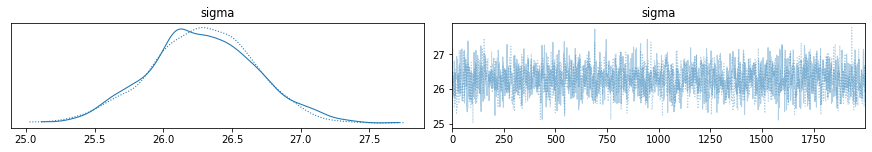

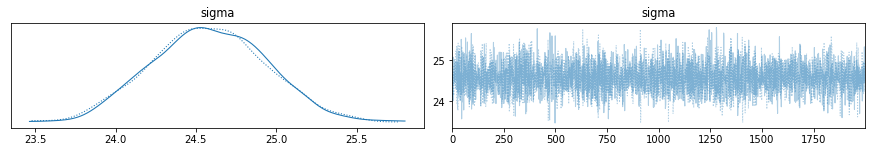

In [16]:
pm3.traceplot(var_names=['sigma'], data=trace_1)
pm3.traceplot(var_names=['sigma'], data=trace_2)

3. We see many entirely flat posteriors of our policy coefficient of some states. First we identify which states they are:

In [17]:
trace2_shall = pm3.summary(data=trace_2).iloc[58:]
trace2_shall[trace2_shall['sd'] >= 100]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Shall_5[4],0.171,115.403,-194.543,179.504,1.390,2.250,6223.0,2359.0,1.0
Shall_5[6],0.089,115.351,-192.949,181.731,1.555,2.179,4868.0,2312.0,1.0
Shall_5[7],-0.531,115.409,-182.832,189.718,1.595,2.246,4829.0,2569.0,1.0
Shall_5[10],-0.071,114.691,-185.437,183.899,1.409,2.074,5296.0,2465.0,1.0
Shall_5[19],-0.092,113.852,-181.768,188.252,1.139,2.375,9810.0,2245.0,1.0
Shall_5[20],-0.260,117.645,-187.140,187.364,1.254,2.338,7464.0,2254.0,1.0
Shall_5[28],0.442,115.667,-176.768,198.666,1.353,2.692,8072.0,1741.0,1.0
Shall_5[29],0.953,115.301,-184.580,187.427,1.415,2.397,5998.0,1919.0,1.0
Shall_5[31],-0.143,115.768,-189.085,183.895,1.557,2.388,4982.0,2562.0,1.0
Shall_5[38],-1.683,117.929,-199.992,178.048,1.237,2.309,8271.0,2247.0,1.0


In [18]:
flat_states = [4, 6, 7, 10, 19, 20, 28, 29, 31, 38, 44, 46]

for state in flat_states:
    print (f"The shall issue law is implemented in state {state} for at least 1 year: {1 in data[data.state == state]['shall_5'].values}")

The shall issue law is implemented in state 4 for at least 1 year: False
The shall issue law is implemented in state 6 for at least 1 year: False
The shall issue law is implemented in state 7 for at least 1 year: False
The shall issue law is implemented in state 10 for at least 1 year: False
The shall issue law is implemented in state 19 for at least 1 year: False
The shall issue law is implemented in state 20 for at least 1 year: False
The shall issue law is implemented in state 28 for at least 1 year: False
The shall issue law is implemented in state 29 for at least 1 year: False
The shall issue law is implemented in state 31 for at least 1 year: False
The shall issue law is implemented in state 38 for at least 1 year: False
The shall issue law is implemented in state 44 for at least 1 year: False
The shall issue law is implemented in state 46 for at least 1 year: False


Thus, we see that the flat posteriors are entirely caused by those states that do **NOT** have the shall-issue law in effect in years 1970-2018. As these coefficients are unpooled, we can safely identify and reduce the effect of these outliers on our modeling accuracy. This is a major advantage of not having a pooled policy coefficient, as we do in Model 2 or 3.trace2_shall

4. The traceplot for $\beta_0$, excluding those outliers mentioned above, shows that the $\beta_0$ posteriors are mostly centered $[-50, 0]$, consistent with our model 1 results that the shall_issue law has an overall effect of reducing robbery rates. However, the unpooled model shows that for some states the law might be useless or may have the exact opposite effect of inducing crimes. The below visualization serves as further support:

Text(0, 0.5, 'mean of beta_0 from sample')

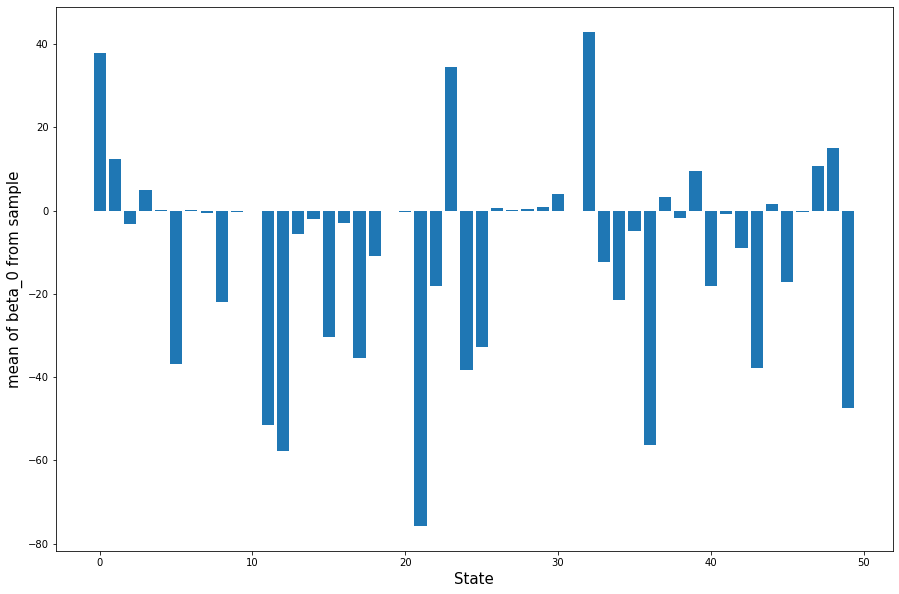

In [19]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.bar(np.arange(0, 50, 1), trace2_shall['mean']);

ax.set_xlabel('State', fontsize=15)
ax.set_ylabel('mean of beta_0 from sample', fontsize=15)

## Model 3: Hierarchical

Finally we estimate a heirarchical model to account for the inter-state similarities of crime-related factors. The model is specified as follows:

Here is the Bayesian model statement for what we'll be estimating handling the treatment effect as a hierarchical variable:

- Priors
\begin{eqnarray}
\mu_{state} &\sim& U(0,800)\nonumber \\
\sigma_{state} &\sim& HalfCauchy(0,5)\nonumber \\
State_i &\sim& N(\mu_{state},\sigma_{state}) \nonumber \\
\mu_{shall} &\sim& U(-200,200)\nonumber \\
\sigma_{shall} &\sim& HalfCauchy(0,3)\nonumber \\
\beta_{0i} &\sim& N(\mu_{shall},\sigma_{shall}) \nonumber\\
\beta_j &\sim& N(0,50), j \in [1,2,...,7]\nonumber \\
\sigma &\sim& HalfCauchy(0, 5) \\
\end{eqnarray}

- Likelihood
\begin{equation}
log(Y_{it}) \sim N(State_i + \beta_{0i}Shall_{it} + \sum_{j=1}^7 {\beta_j Control_{j,it}}, \sigma) \nonumber
\end{equation}


### Results:

In [9]:
with pm3.Model() as model_3:
    # Hyperpriors
    mu_state = pm3.Uniform('mu_state', lower=0, upper=800)
    sigma_state = pm3.HalfCauchy('sigma_state', beta=5)
    mu_shall = pm3.Uniform('mu_shall', lower=-200, upper=200)
    sigma_shall = pm3.HalfCauchy('sigma_shall', beta=3)
    
    # Intercept for each state, distributed around group mean mu_state
    state_offset = pm3.Normal('state_offset', mu=0., sigma=1., shape=state_n)
    #beta0 = pm3.Deterministic('beta0', mu_beta0 + sigma_beta0 * beta0_offset)
    state = pm3.Deterministic('state', mu_state + sigma_state * state_offset)
    
    # Slope for each state, distributed around group mean mu_shall
    shall_offset = pm3.Normal('shall_offset', mu=0, sigma=1, shape=state_n)
    #shall = pm3.Normal('shall', mu=mu_shall, sigma=sigma_shall, shape=state_n)
    shall = pm3.Deterministic('shall', mu_shall + sigma_shall * shall_offset)

    
    b_controls = pm3.Normal("b_controls", mu=0, sigma=50, shape=control_n)
    
    # std of likelihood
    sigma = pm3.HalfCauchy('std', beta=5)
    
    # Expected value
    mu_it = state[state_idx] + shall[state_idx] * data.shall_5 + t.dot(data.iloc[:, 4:11].values, b_controls)
    
    # Data likelihood
    y_like = pm3.Normal('y_like', mu=mu_it, sigma=sigma, observed=data.lcrrobpc)

In [ ]:
with model_3:
    trace_3 = pm3.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [std, b_controls, shall_offset, state_offset, sigma_shall, mu_shall, sigma_state, mu_state]


In [ ]:
pm3.plot_trace(trace_3)

### Discussions

1. The state intercepts are identically distributed as those of model 2. 

In [ ]:
pm3.traceplot(var_names=['State Intercept'], data=trace_2)
pm3.traceplot(var_names=['state'], data=trace_3)

2. $\beta_0$ of those states that never implemented the shall-issue law have less flat posterior distributions, potentially caused by the parent priors. As expected, the $\beta_0$s show much less heterogeneity across states, the result of using a parent distribution.

In [ ]:
pm3.traceplot(var_names=['Shall_5'], data=trace_2)
pm3.traceplot(var_names=['shall'], data=trace_3)

In [ ]:
trace3_shall = pm3.summary(data=trace_3).loc['shall[0]':'shall[49]']

x_axis = np.arange(50)

plt.figure(figsize=(12,10))
plt.bar(x_axis -0.2, trace2_shall['mean'].values, width=0.4, label = 'model 2')
plt.bar(x_axis +0.2, trace3_shall['mean'].values, width=0.4, label = 'model 3')

plt.xlabel('State', fontsize=15)
plt.ylabel('mean of beta_0 from sample',fontsize=15)

plt.legend(fontsize=15)

## Model Comparison

We use the Widely Available Information Criteria (WAIC) to compare our three models. This is analogous to the cross-validation in machine learning applications.

In [ ]:
pm3.compare({'Model 1': trace_1, 'Model 2': trace_2, 'Model 3': trace_3}, ic='waic')

After running our sampling multiple times, we see that our model 2 and model 3 have similar waic scores and standard errors, and that which one has the lowest score depends on the specific samples. The fact that our unpooled and hierarchical model prevail among the three provides further evidence that state level heterogeneities in robbery rate levels as well as policy efficacies cannot be ignored.

## Conclusion

In our study, we used a mixed, unpooled and a hierarchical model to estimate the effect of implementing the shall-issue law on robbery rate. We see that although all three models converged, our unpooled model and hierarchical model greatly outperformed the pooled model. We find that although significant state-level heterogeneities are present, all three models show that the passing of the law reduces robbery rates in the long run, supporting the claims of Benson and Mast (2001). However, we must not overgeneralize, as for some states the law seems to be crime-inducing if not ineffective. Further research should be directed towards these states so that we gain a better understanding of why the shall-issue laws failed to deliver in these places.